In [1]:
import pandas as pd
import numpy as np
import math

from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

In [2]:

df1 = pd.read_csv('combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


In [3]:
df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::50000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
50000      211008     3.0
100000    1732588     4.0
150000     625405     5.0
200000    1842450     5.0
...           ...     ...
23850000  2538271     5.0
23900000   836232     3.0
23950000   204049     3.0
24000000   517002     4.0
24050000   650088     3.0

[482 rows x 2 columns]


In [4]:


df1.index = np.arange(0,len(df1))
print('Full dataset shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::50000, :])

Full dataset shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
50000      211008     3.0
100000    1732588     4.0
150000     625405     5.0
200000    1842450     5.0
...           ...     ...
23850000  2538271     5.0
23900000   836232     3.0
23950000   204049     3.0
24000000   517002     4.0
24050000   650088     3.0

[482 rows x 2 columns]


In [5]:
df1.shape

(24058263, 2)

In [6]:


#
p = df1.groupby('Rating')['Rating'].agg(['count'])
# get movie count
movie_count = df1.isnull().sum()[1]
#get customer count
cust_count = df1['Cust_Id'].nunique() - movie_count
# get rating count
rating_count = df1['Cust_Id'].count() - movie_count


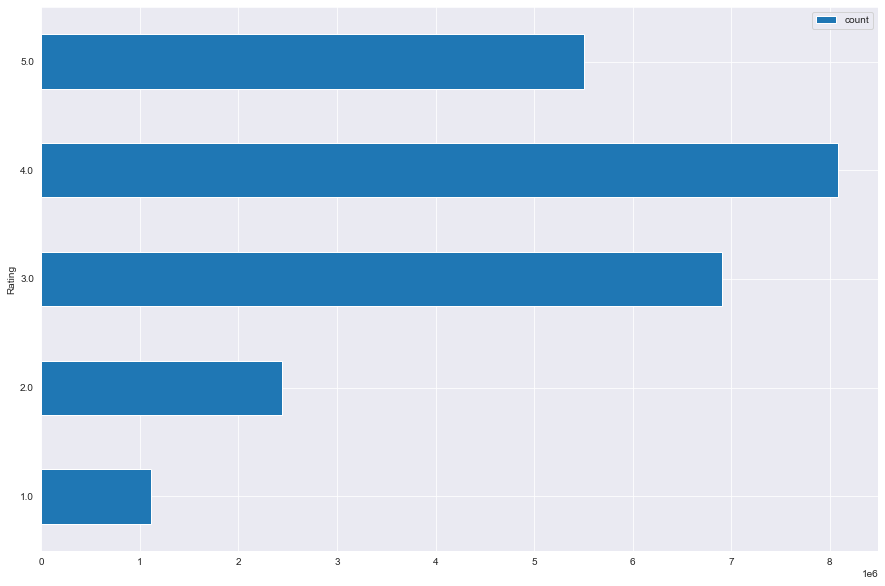

In [7]:
p.plot(kind="barh",figsize=(15,10));

,level_0,index,Rating
0,0,4106,True
1,1,5071,True
2,2,10333,True
3,3,12782,True
4,4,16451,True
5,5,20151,True
6,6,20854,True


In [8]:
df_nan=pd.DataFrame(pd.isnull(df1.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()


In [9]:
movie_np = []
movie_id = 1

In [10]:
for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

In [11]:
# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df1) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)
movie_np
print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))


Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [19]:
# remove those Movie ID rows
df1 = df1[pd.notnull(df1['Rating'])]

df1['Movie_Id'] = movie_np.astype(int)
df1['Cust_Id'] = df1['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df1.iloc[::5000000, :])
df1=df1.sample(50000)

-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


In [47]:
f = ['count','mean']

df_movie_summary = df1.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df1.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))
df = df1[~df1['Movie_Id'].isin(drop_movie_list)]
df = df1[~df1['Cust_Id'].isin(drop_cust_list)]

Movie minimum times of review: 9.0
Customer minimum times of review: 1.0


In [48]:
df_p = pd.pivot_table(df1,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)
df_p

(43401, 2907)


Movie_Id,3,5,8,12,14,15,16,17,18,23,...,4485,4487,4488,4490,4491,4492,4493,4495,4496,4497
Cust_Id,,,,,,,,,,,,,,,,,,,,,
87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2649288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:

df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


In [50]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df1[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([1.03728164, 1.0251335 , 1.02983073, 1.03260491, 1.0309451 ]),
 'test_mae': array([0.83977708, 0.82492049, 0.83219909, 0.82966286, 0.83607917]),
 'fit_time': (2.8832321166992188,
  3.111952066421509,
  2.9683310985565186,
  3.1555449962615967,
  3.1475796699523926),
 'test_time': (0.07778787612915039,
  0.07779192924499512,
  0.06682205200195312,
  0.18550395965576172,
  0.12267327308654785)}

In [53]:
df_785314 = df1[(df1['Cust_Id'] == 785314) & ((df1['Rating'] <=4) )]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)

Movie_Id
2209    On Golden Pond
Name: Name, dtype: object


In [54]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))


        Year                       Name  Estimate_Score
3961  2003.0  Finding Nemo (Widescreen)        4.993520
3455  2004.0             Lost: Season 1        4.698226
3741  1946.0                  Notorious        4.617749
3927  2004.0         Nip/Tuck: Season 2        4.613109
1356  2003.0    Stargate SG-1: Season 7        4.579118
2171  1991.0     The Simpsons: Season 3        4.563039
2781  1995.0                 Braveheart        4.544728
2802  1995.0        Pride and Prejudice        4.530221
4305  1999.0            The Sixth Sense        4.512581
190   2003.0           X2: X-Men United        4.493778
